In [74]:
#|default_exp lunarlander

In [75]:
#|export
# Import the relevant libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gym
import time
import random
import pandas as pd
from collections import deque, namedtuple
from pyvirtualdisplay import Display
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
from PIL import Image
import PIL

In [76]:
#|export 
# Initialize all the parameters
MEMORY_SIZE = 100000    
GAMMA = 0.995            
LEARNING_RATE = 1e-3               
NUM_STEPS_FOR_UPDATE = 4 
SEED = 0              
MINIBATCH_SIZE = 64   
TAU = 1e-3           
E_DECAY = 0.995      
E_MIN = 0.01       

# Using Namedtuple to store the experience
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

# Set the seed
random.seed(SEED)

In [77]:
#|export
# Initialize the gym environment
env = gym.make('LunarLander-v2')
env = gym.make("LunarLander-v2", render_mode="human")
state_size = env.observation_space.shape
num_actions = env.action_space.n

In [78]:
#|export
# Define the models and optimizer
q_network = Sequential([
    Input(shape=state_size),
    Dense(64,activation='relu'),
    Dense(64,activation='relu'),
    Dense(num_actions,activation='linear')
]) 

target_q_network = Sequential([
    Input(shape=state_size),
    Dense(64,activation='relu'),
    Dense(64,activation='relu'),
    Dense(num_actions,activation='linear')
]) 

optimizer = Adam(learning_rate=LEARNING_RATE)

In [79]:
#|export
# Define the loss function
def compute_loss(experiences, gamma, q_network, target_q_network):
    
    states, actions,rewards,next_states,done_vals = experiences
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))
    loss = MSE(y_targets, q_values)
    return loss

In [80]:
#|export
# Define the update step
@tf.function
def agent_learn(experiences, gamma):    
    # Calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)
    
    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of target q_network
    for target_weights, q_net_weights in zip(target_q_network.weights, q_network.weights):
        target_weights.assign(TAU * q_net_weights + (1.0 - TAU) * target_weights)

In [81]:
#|export
# Function to retrieve the experiences
def get_experiences(memory_buffer):
    experiences = random.sample(memory_buffer, k=MINIBATCH_SIZE)
    states = tf.convert_to_tensor(np.array([e.state for e in experiences if e is not None]),dtype=tf.float32)
    actions = tf.convert_to_tensor(np.array([e.action for e in experiences if e is not None]), dtype=tf.float32)
    rewards = tf.convert_to_tensor(np.array([e.reward for e in experiences if e is not None]), dtype=tf.float32)
    next_states = tf.convert_to_tensor(np.array([e.next_state for e in experiences if e is not None]),dtype=tf.float32)
    done_vals = tf.convert_to_tensor(np.array([e.done for e in experiences if e is not None]).astype(np.uint8),
                                     dtype=tf.float32)
    return (states, actions, rewards, next_states, done_vals)

In [82]:
#|export 
# Funtion to check for the update condition
def check_update_conditions(t, num_steps_upd, memory_buffer):
    if (t + 1) % num_steps_upd == 0 and len(memory_buffer) > MINIBATCH_SIZE:
        return True
    else:
        return False

In [83]:
#|export 
# Function to update and get the new epsilon
def get_new_eps(epsilon):
    return max(E_MIN, E_DECAY*epsilon)

In [84]:
#|export
# Function to get the next action
def get_action(q_values, epsilon=0):
    if random.random() > epsilon:
        return np.argmax(q_values.numpy()[0])
    else:
        return random.choice(np.arange(4))


In [85]:
#|export
# The training loop
start = time.time()

num_episodes = 2000
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):
    
    # Reset the environment to the initial state and get the initial state
    state = env.reset()
    total_points = 0

    for t in range(max_num_timesteps):

        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state[0], axis=0)  # state needs to be the right shape for the q_network

        q_values = q_network(tf.convert_to_tensor(state_qn,dtype=tf.float32))
        action = get_action(q_values, epsilon)
        
        # Take action A and receive reward R and the next state S'
        next_state, reward, terminated, truncated,_ = env.step(action)
        done = (terminated or truncated)
        
        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state[0], action, reward, next_state, done))
        
        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
        
        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = get_experiences(memory_buffer)
            
            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            agent_learn(experiences, GAMMA)
        
        state = (next_state.copy(),_)
        total_points += reward
        
        if done:
            break
            
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
    
    # Update the ε value
    epsilon = get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('lunar_lander_model.h5')
        break
        
tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 5 | Total point average of the last 100 episodes: -198.72

KeyboardInterrupt: 

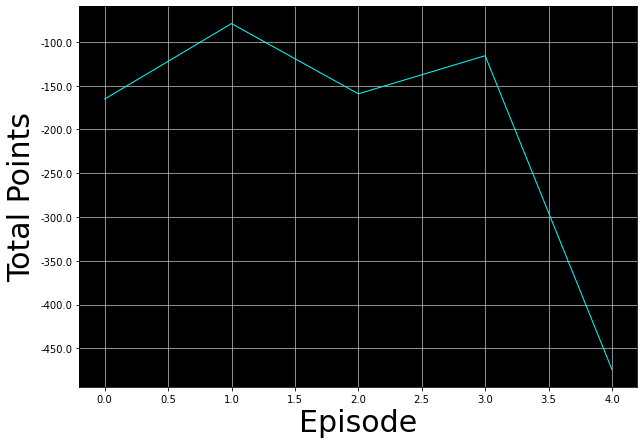

In [86]:
#|export
# Plot the point history
import matplotlib.ticker as mticker

def plot_history(reward_history, rolling_window=20, lower_limit=None,
                 upper_limit=None, plot_rw=True, plot_rm=True):
    
    if lower_limit is None or upper_limit is None:
        rh = reward_history
        xs = [x for x in range(len(reward_history))]
    else:
        rh = reward_history[lower_limit:upper_limit]
        xs = [x for x in range(lower_limit,upper_limit)]
    
    df = pd.DataFrame(rh)
    rollingMean = df.rolling(rolling_window).mean()

    plt.figure(figsize=(10,7), facecolor='white')
    
    if plot_rw:
        plt.plot(xs, rh, linewidth=1, color='cyan')
    if plot_rm:
        plt.plot(xs, rollingMean, linewidth=2, color='magenta')
    text_color = 'black'
        
    ax = plt.gca()
    ax.set_facecolor('black')
    plt.grid()
#     plt.title("Total Point History", color=text_color, fontsize=40)
    plt.xlabel('Episode', color=text_color, fontsize=30)
    plt.ylabel('Total Points', color=text_color, fontsize=30)
    yNumFmt = mticker.StrMethodFormatter('{x:,}')
    ax.yaxis.set_major_formatter(yNumFmt)
    ax.tick_params(axis='x', colors=text_color)
    ax.tick_params(axis='y', colors=text_color)
    plt.show()

plot_history(total_point_history)

In [1]:
import nbdev
nbdev.export.nb_export('lunarlander.ipynb','lunarlander.py')

UnicodeEncodeError: 'charmap' codec can't encode character '\u03b5' in position 248: character maps to <undefined>